Analysing Stress Periods

# Introduction

This workbook identifies and provides a base for analysing the stress period for a portfolio.

The historical P&L values are loaded for each position or trade and these are aggregated to the portfolio level.  We identify the stress period, by looking at a sliding window over the P&L values.  The stress period corresponds to the window with the greatest stress (i.e. greatest VaR value).

Then, we can analyse this stress period looking at how the VaR decomposes by risk-class or trade-level attributes.

## Contents and Status

This notebook is still a work in progress.

In this notebook, we:
* create the cube, load the data
* query the cube for the aggregate P&L vector
* in python using sliding windows, determine the stress period
* further analysis decomposing the VaR calculation (by desk).

## Libraries

We use [atoti](https://docs.atoti.io/0.3.1/installation.html) for the aggregation and slicing and dicing of the data, [scipy](https://www.scipy.org/install.html) for analysis, and [matplotlib](https://matplotlib.org/users/installing.html) for graphing.


In [1]:
import atoti as tt
import matplotlib.pyplot as plt
import math
from scipy import stats
import numpy as np

Welcome to Atoti 0.3.1.20200406182105!

By using this community edition, you agree with the license available at https://atoti.io/eula.
Browse the official documentation at https://atoti.io/documentation.
Join the community at https://atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


# Building the Atoti Cube

Create the session

In [2]:
session = tt.create_session()

Load the data

In [3]:
trades_store = session.read_csv("trade-pl.csv", keys=["TradeId", "AsOfDate"], store_name="trades", array_sep=";")
trades_store.head()

,,Desk,PnLVector
TradeId,AsOfDate,,
IMA_FX_1,2017-08-29,DeskA,"doubleVector[32]{-10000.0, ...}"
IMA_FX_2,2017-08-29,DeskA,"doubleVector[36]{-761.94, ...}"
IMA_FX_3,2017-08-29,DeskA,"doubleVector[260]{46.61, ...}"
IMA_Comm_1,2017-08-29,DeskA,"doubleVector[35]{-925.08, ...}"
IMA_FX_5,2017-08-29,DeskA,"doubleVector[36]{-882.7, ...}"


Create the Atoti Cube

In [4]:
cube = session.create_cube(trades_store, "Cube")
m = cube.measures
lvl = cube.levels

# Query the Cube

We query the cube for the P&L values aggregated to the full portfolio

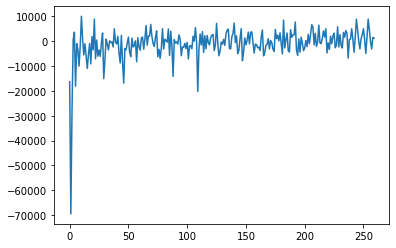

In [5]:
pl = np.array(cube.query(m["PnLVector.SUM"])["PnLVector.SUM"][0])

plt.plot(pl)
plt.show()

# VaR Calculation

We define the confidence level and window size that we are looking at.

We construct an L-Estimator kernel, which we will use to calculate the VaR values.  The VaR is calculated by multiplying the kernel with the sorted P&L window.

In [6]:
confidence_level = 0.95
quantile = 1 - confidence_level
window_size = 100

kernel = np.zeros(window_size)
quantile_rank = math.floor(quantile * window_size)
kernel[quantile_rank - 1] = 1

def var(pl): return -np.dot(np.sort(pl), kernel)

## Alternative VaR caluation using np.quantile()
# def var(pl): return -np.quantile(pl, quantile, interpolation='lower')

Calculate and plot the portfolio VaR value for each period

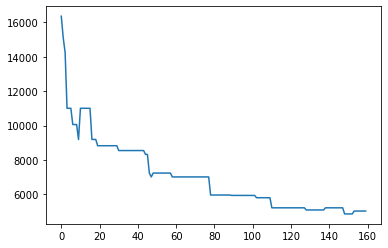

In [7]:
period_indices = range(0, len(pl) - window_size)

vars = np.array([var(pl[i:i + window_size]) for i in period_indices])
plt.plot(vars)
plt.show()

The maximum VaR value

In [8]:
max_var = np.max(vars)
max_var

16360.562000000005

The periods where the VaR value is equal to the maximum.  Because the VaR is a tail measure, it only depends on the lowest handful of values, and these can be shared by multiple periods.

In [9]:
max_periods = np.argwhere(vars == max_var).flatten()
max_periods

array([0], dtype=int64)

Pick the most recent to be the stress period.

Plot the (sorted) P&L values for the stress period

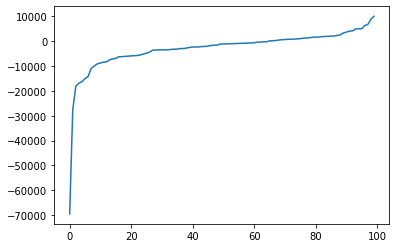

In [10]:
period = max_periods[-1]
pl_period = pl[period:period + window_size]
plt.plot(np.sort(pl_period))
plt.show()

# Decomposition

**TODO:** With better data, change level to risk-class 

In [11]:
decomp_level = lvl["Desk"]

## Defining Component VaR Calculations

Using the ordering of the P&L values for the portfolio P&L vector windows, we can calculate the contribution to the VaR for subsets of the portfolio.

We start by storing the sort order of the portfolio P&L vector for each window, then calculate the sub-portfolio VaR based on this sort order and the kernel

In [12]:
# For each window, the sort order of the portfolio P&L values
sort_indices = np.array([np.argsort(pl[i:i + window_size]) for i in period_indices])

def VaR_decomp_kernel(pl, i, kernel): return -sum([pl[i + sort_indices[i][j]] * kernel[j] for j in range(window_size)])
def VaR_decomp_period(pl, i): return VaR_decomp_kernel(pl, i, kernel)
def VaR_decomp_all(pl): return np.array([VaR_decomp_period(pl,i) for i in period_indices])

Check that this gives the same values when applied to the full portfolio.

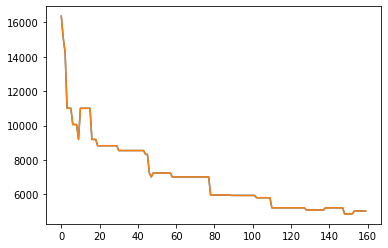

0.0

In [13]:
vars2 = VaR_decomp_all(pl)
plt.plot(vars2)
plt.plot(vars)
plt.show()

# Check: max over all windows of difference between the VaR values calculated using each method
max(vars2-vars)

## Querying the Cube for Component P&L Vectors

Now we query the cube for the P&L vectors aggregated to the decomposition level (i.e. risk-class)

In [14]:
decomp_results = cube.query(m["PnLVector.SUM"], levels=[decomp_level])
decomp_results

,PnLVector.SUM
Desk,
DeskA,"[-15096.666000000001, -70250.38199999998, -140..."
DeskB,"[-1263.8960000000002, 788.874, -13639.694, 107..."


## Calculating Component VaR

We calculate the VaR values for each member of the decomposition level and for each window.

Graphing the decomposition for all windows, and returning the decomposition values for the stress period

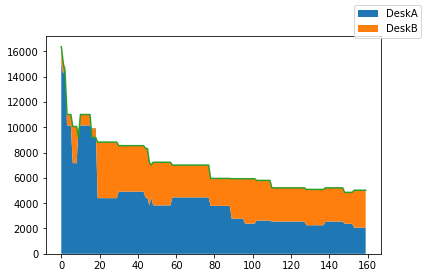

[['DeskA', 15096.666000000001], ['DeskB', 1263.8960000000002]]

In [15]:
decomp_vars = np.array([[row[0], VaR_decomp_all(row[1])] for row in decomp_results.itertuples()])

plt.stackplot(period_indices, *decomp_vars[:,1], labels=decomp_vars[:,0])
plt.figlegend()
plt.plot(vars)
plt.show()

[[row[0], row[1][period]] for row in decomp_vars]